# Предобработка

In [ ]:
pip install catboost

     |████████████████████████████████| 66.3MB 62kB/s 


In [ ]:
pip install pycountry

     |████████████████████████████████| 10.1MB 6.5MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=a7999e4c2f145639eb582a709b3348ac8cc47de68c3cbec2a20ee008d81de1c9
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [ ]:
pip install cyrtranslit

  Created wheel for cyrtranslit: filename=cyrtranslit-0.4-cp36-none-any.whl size=5080 sha256=c6ad560f5b6b22a7b9623f02afd2783575d7266e51947be83b535e390f2612b3
  Stored in directory: /root/.cache/pip/wheels/05/06/cb/25964247b9a73ba8b11761d0cdebedc2cafbd9c031f0e05b04
Successfully built cyrtranslit


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import re
import keras
import pycountry
import cyrtranslit
from tqdm import tqdm
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, f1_score
from scipy.sparse import hstack
from sklearn.model_selection import cross_val_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

In [ ]:
train = pd.read_csv('https://sibur.ai-community.com/files/uploads/f2a0fcc002869df7f84bfbed0624cce5/train.csv', index_col='pair_id')
train

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...
497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0


In [ ]:
train

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...
497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [ ]:
train.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [ ]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [ ]:
porter = PorterStemmer()
def stemming(sentence):
    word_list = []
    for i in sentence.split():
        word_list.append(porter.stem(i))
    word_list = " ".join(word_list)
    return " ".join(re.sub(r'[^A-Za-z]', " ", word_list).split())

In [ ]:
train

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...
497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0


In [ ]:
train['name_1'] = train['name_1'].apply(stemming).copy()
train['name_2'] = train['name_2'].apply(stemming)
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industri ltd,enorm industri trade pvt ltd,0
2,apcotex industri ltd,technocraft industri india ltd,0
3,rishichem distributor pvt ltd,dsa,0
4,powermax rubber factori,co one,0
5,tress a,longyou industri park zhejiang,0


In [ ]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

train["tokens1"] = train['name_1'].apply(tokenizer.tokenize)
train["tokens2"] = train['name_2'].apply(tokenizer.tokenize)
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2
pair_id,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,"[iko, industri, ltd]","[enorm, industri, trade, pvt, ltd]"
2,apcotex industri ltd,technocraft industri india ltd,0,"[apcotex, industri, ltd]","[technocraft, industri, india, ltd]"
3,rishichem distributor pvt ltd,dsa,0,"[rishichem, distributor, pvt, ltd]",[dsa]
4,powermax rubber factori,co one,0,"[powermax, rubber, factori]","[co, one]"
5,tress a,longyou industri park zhejiang,0,"[tress, a]","[longyou, industri, park, zhejiang]"


In [ ]:
all_words = [word for tokens in train["tokens1"] for word in tokens]
for tokens in train["tokens1"]:
    for word in tokens:
        all_words.append(word)
len(all_words)

3863104

In [ ]:
Counter(all_words).most_common(30)

[('ltd', 277792),
 ('co', 159080),
 ('inc', 99474),
 ('intern', 97998),
 ('industri', 96926),
 ('De', 90854),
 ('trade', 67398),
 ('a', 57388),
 ('logist', 54966),
 ('s', 54790),
 ('pvt', 42844),
 ('rubber', 42316),
 ('india', 35938),
 ('privat', 33700),
 ('Sa', 32914),
 ('llc', 31448),
 ('S', 31402),
 ('Cv', 29022),
 ('ltda', 28142),
 ('c', 27946),
 ('chemic', 26320),
 ('product', 24584),
 ('plastic', 22944),
 ('mexico', 22680),
 ('shanghai', 22680),
 ('imp', 21198),
 ('v', 20936),
 ('corpor', 20906),
 ('corp', 20824),
 ('exp', 20406)]

In [ ]:
stop_words = []
for x, _ in Counter(all_words).most_common(30):
    stop_words.append(x)  

In [ ]:
stop_words = set(stop_words)

In [ ]:
number = 1
for token in train["tokens1"]:
    seq = []
    for word in token:
        if (word not in stop_words) and (len(word) >= 3):
          seq.append(word)
    train["tokens1"][number] = " ".join(seq)
    number += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
train

,name_1,name_2,is_duplicate,tokens1,tokens2
pair_id,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,"[enorm, industri, trade, pvt, ltd]"
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,"[technocraft, industri, india, ltd]"
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,[dsa]
4,powermax rubber factori,co one,0,powermax factori,"[co, one]"
5,tress a,longyou industri park zhejiang,0,tress,"[longyou, industri, park, zhejiang]"
...,...,...,...,...,...
497815,bit mat product,the goodyear tire and rubber compani,0,bit mat,"[the, goodyear, tire, and, rubber, compani]"
497816,bnd trade co ltd,zhong shan yue liang economy trade imp exp co ltd,0,bnd,"[zhong, shan, yue, liang, economy, trade, imp,..."
497817,xeikon industri co ltd Of dongguan citi,Yi cheng trade co ltd Of dongguan citi,0,xeikon dongguan citi,"[Yi, cheng, trade, co, ltd, Of, dongguan, citi]"


In [ ]:
number = 1
for token in train["tokens2"]:
    seq = []
    for word in token:
        if (word not in stop_words) and (len(word) >= 3):
          seq.append(word)
    train["tokens2"][number] = " ".join(seq)
    number += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2
pair_id,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa
4,powermax rubber factori,co one,0,powermax factori,one
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang


In [ ]:
test = pd.read_csv('https://sibur.ai-community.com/files/uploads/330714924ed1c66420d6186c0a085fe5/test.csv', index_col='pair_id')
test['name_1'] = test['name_1'].apply(stemming).copy()
test['name_2'] = test['name_2'].apply(stemming)
test["tokens1"] = test['name_1'].apply(tokenizer.tokenize)
test["tokens2"] = test['name_2'].apply(tokenizer.tokenize)
test.head()

,name_1,name_2,tokens1,tokens2
pair_id,,,,
1,sun blind decor inc,indl De cuautitlan Sa Cv,"[sun, blind, decor, inc]","[indl, De, cuautitlan, Sa, Cv]"
2,eih ltd,dongguan wei shi plastic product co ltd,"[eih, ltd]","[dongguan, wei, shi, plastic, product, co, ltd]"
3,jsh ltd hk,arab shipbuild and repair yard C,"[jsh, ltd, hk]","[arab, shipbuild, and, repair, yard, C]"
4,better industri ltd,farmacap industria E comercio ltda,"[better, industri, ltd]","[farmacap, industria, E, comercio, ltda]"
5,equipo inoxid del nort Sa De Cv,bel inc,"[equipo, inoxid, del, nort, Sa, De, Cv]","[bel, inc]"


In [ ]:
number = 1
for token in test["tokens1"]:
    seq = []
    for word in token:
        if (word not in stop_words) and (len(word) >= 3):
          seq.append(word)
    test["tokens1"][number] = " ".join(seq)
    number += 1

In [ ]:
test.head()

,name_1,name_2,tokens1,tokens2
pair_id,,,,
1,sun blind decor inc,indl De cuautitlan Sa Cv,sun blind decor,"[indl, De, cuautitlan, Sa, Cv]"
2,eih ltd,dongguan wei shi plastic product co ltd,eih,"[dongguan, wei, shi, plastic, product, co, ltd]"
3,jsh ltd hk,arab shipbuild and repair yard C,jsh,"[arab, shipbuild, and, repair, yard, C]"
4,better industri ltd,farmacap industria E comercio ltda,better,"[farmacap, industria, E, comercio, ltda]"
5,equipo inoxid del nort Sa De Cv,bel inc,equipo inoxid del nort,"[bel, inc]"


In [ ]:
number = 1
for token in test["tokens2"]:
    seq = []
    for word in token:
        if (word not in stop_words) and (len(word) >= 3):
          seq.append(word)
    test["tokens2"][number] = " ".join(seq)
    number += 1

In [ ]:
test.head()

,name_1,name_2,tokens1,tokens2
pair_id,,,,
1,sun blind decor inc,indl De cuautitlan Sa Cv,sun blind decor,indl cuautitlan
2,eih ltd,dongguan wei shi plastic product co ltd,eih,dongguan wei shi
3,jsh ltd hk,arab shipbuild and repair yard C,jsh,arab shipbuild and repair yard
4,better industri ltd,farmacap industria E comercio ltda,better,farmacap industria comercio
5,equipo inoxid del nort Sa De Cv,bel inc,equipo inoxid del nort,bel


In [ ]:
countries = [country.name.lower() for country in pycountry.countries]
for country in tqdm(countries):
    train['tokens1'].replace(re.compile(country), "", inplace=True)
    train['tokens2'].replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [04:23<00:00,  1.06s/it]


In [ ]:
countries = [country.name.lower() for country in pycountry.countries]
for country in tqdm(countries):
    test['tokens1'].replace(re.compile(country), "", inplace=True)
    test['tokens2'].replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [01:52<00:00,  2.22it/s]


In [ ]:
number = 1
for string in train['tokens1']:
    new_str = ''
    new_str = cyrtranslit.to_latin(string)
    print(string, new_str)
    #train['tokens1'] = new_str
    number += 1

Streaming output truncated to the last 5000 lines.
westgat efi westgat efi
sia engin philipines sia engin philipines
htp htp
 
manufactura proceso industrial manufactura proceso industrial
zen metarlugica zen metarlugica
rise star mobil rise star mobil
nile air nile air
eia eia
plasdecol plasdecol
alcatel lucent shinco perform elastom changzhou have alcatel lucent shinco perform elastom changzhou have
cherri cherri
oun oun
guangzhou shine guangzhou shine
mar chocol north america mar chocol north america
qingdao zhenhua qingdao zhenhua
electricfil electricfil
fenner dunlop america fenner dunlop america
assa roof solut assa roof solut
mar mar
eia eia
lathia mfg lathia mfg
pigipada limit liabil compani pigipada limit liabil compani
aim aim
chongq jinmao chongq jinmao
std std
kosana kosana
qingdao branch smart machineri qingdao branch smart machineri
televis electron televis electron
texxon texxon
 
arlanxeo brasil arlanxeo brasil
proyecto diagnostico industrial prodin proyecto diagnostico

KeyboardInterrupt: ignored

In [ ]:
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2
pair_id,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm
2,apcotex industri ltd,technocraft industri india ltd,0,iko,technocraft
3,rishichem distributor pvt ltd,dsa,0,iko,dsa
4,powermax rubber factori,co one,0,iko,one
5,tress a,longyou industri park zhejiang,0,iko,longyou park zhejiang


In [ ]:
a = cyrtranslit.to_latin('hello')
a

'hello'

# Простые метрики сходства строк

## Левенштейн

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
 3   tokens1       497819 non-null  object
 4   tokens2       497819 non-null  object
dtypes: int64(1), object(4)
memory usage: 42.8+ MB


In [ ]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from tqdm import tqdm
tqdm.pandas()

/Users/yakovlev/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
levenshtein = Levenshtein()

train["levenstein"] = train.apply(lambda r: levenshtein.distance(r.tokens1, r.tokens2), axis=1)
test["levenstein"] = test.apply(lambda r: levenshtein.distance(r.tokens1, r.tokens2), axis=1)

In [ ]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.apply(lambda r: normalized_levenshtein.distance(r.tokens1, r.tokens2),
                                                axis=1)
test["norm_levenstein"] = test.apply(lambda r: normalized_levenshtein.distance(r.tokens1, r.tokens2),
                                              axis=1)

In [ ]:
train.to_csv('sibur_train_levenstein.csv',)
test.to_csv('sibur_test_levenstein.csv', )

In [ ]:
print('mean для класса 1', train[train['is_duplicate'] == 1]['norm_levenstein'].mean())

mean для класса 1 0.4637299404035952


In [ ]:
print('mean для класса 0', train[train['is_duplicate'] == 0]['norm_levenstein'].mean())

mean для класса 0 0.8587755869025424


In [ ]:
test.head()

,name_1,name_2,tokens1,tokens2,levenstein,norm_levenstein
pair_id,,,,,,
1,sun blind decor inc,indl De cuautitlan Sa Cv,sun blind decor,indl cuautitlan,15.0,1.000000
2,eih ltd,dongguan wei shi plastic product co ltd,eih,wei shi,4.0,0.571429
3,jsh ltd hk,arab shipbuild and repair yard C,jsh,arab shipbuild repair yard,24.0,0.923077
4,better industri ltd,farmacap industria E comercio ltda,better,farmacap,8.0,1.000000
5,equipo inoxid del nort Sa De Cv,bel inc,equipo inoxid del nort,bel,20.0,0.909091


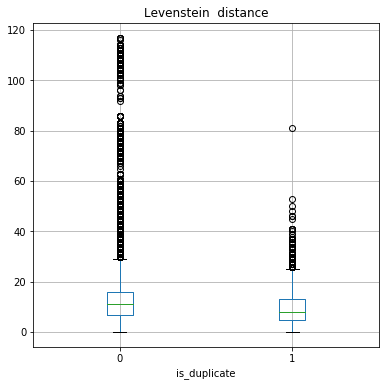

In [ ]:
plt.figure(figsize=(6,6))

train.boxplot("levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

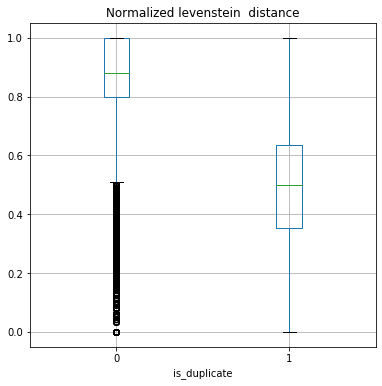

In [ ]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

## Джакар

Реализация Jacaard Similiarity

In [ ]:
def get_jaccard_sim(row):
    if (row['name_1'] == '') or (row['name_2'] == ''):
        return 0
    else:
        a = set(row['name_1'].split()) 
        b = set(row['name_2'].split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein
pair_id,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.800000
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft,9.0,0.818182
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa,19.0,0.904762
4,powermax rubber factori,co one,0,powermax factori,one,14.0,0.875000
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang,19.0,0.904762


In [ ]:
a = train.copy()
b = test.copy()

In [ ]:
a

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein
pair_id,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.800000
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft,9.0,0.818182
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa,19.0,0.904762
4,powermax rubber factori,co one,0,powermax factori,one,14.0,0.875000
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang,19.0,0.904762
...,...,...,...,...,...,...,...
497815,bit mat product,the goodyear tire and rubber compani,0,bit mat,goodyear compani,13.0,0.812500
497816,bnd trade co ltd,zhong shan yue liang economy trade imp exp co ltd,0,bnd,zhong shan yue liang economy,27.0,0.964286
497817,xeikon industri co ltd Of dongguan citi,Yi cheng trade co ltd Of dongguan citi,0,xeikon citi,cheng citi,6.0,0.545455


In [ ]:
b['jacaard_sim'] = b.apply(get_jaccard_sim, axis=1)

In [ ]:
train['jacaard_sim'] = train.apply(get_jaccard_sim, axis=1)
test['jacaard_sim'] = test.apply(get_jaccard_sim, axis=1)

In [ ]:
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim
pair_id,,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.800000,0.333333
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft,9.0,0.818182,0.400000
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa,19.0,0.904762,0.000000
4,powermax rubber factori,co one,0,powermax factori,one,14.0,0.875000,0.000000
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang,19.0,0.904762,0.000000


In [ ]:
test.head()

,name_1,name_2,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim
pair_id,,,,,,,
1,sun blind decor inc,indl De cuautitlan Sa Cv,sun blind decor,indl cuautitlan,15.0,1.000000,0.000
2,eih ltd,dongguan wei shi plastic product co ltd,eih,wei shi,4.0,0.571429,0.125
3,jsh ltd hk,arab shipbuild and repair yard C,jsh,arab shipbuild repair yard,24.0,0.923077,0.000
4,better industri ltd,farmacap industria E comercio ltda,better,farmacap,8.0,1.000000,0.000
5,equipo inoxid del nort Sa De Cv,bel inc,equipo inoxid del nort,bel,20.0,0.909091,0.000


## Cosine similarity

In [ ]:
from scipy import spatial

Обучим tfidf на большом корпусе слов, для этого заканкатим tokens1 и tokens2 у train выборки

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
corpus = pd.concat([train['tokens1'], train['tokens2']]).values.astype('U')
len(corpus)

995638

In [ ]:
tfidf.fit(corpus)

TfidfVectorizer()

In [ ]:
tf_tokens_1 = tfidf.transform(train['tokens1'])
tf_tokens_1.shape

(497819, 14555)

In [ ]:
tf_tokens_1.getrow(0).A[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
tf_tokens_2 = tfidf.transform(train['tokens2'])
tf_tokens_2.shape

(497819, 14555)

In [ ]:
li = []
for i in range(tf_tokens_1.shape[0]):
    li.append(1 - spatial.distance.cosine(tf_tokens_1.getrow(i).A[0], tf_tokens_2.getrow(i).A[0]))

/Users/yakovlev/opt/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [ ]:
len(li)

497819

In [ ]:
train['cos_sim'] = li
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim
pair_id,,,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.800000,0.333333,0.0
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft,9.0,0.818182,0.400000,0.0
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa,19.0,0.904762,0.000000,0.0
4,powermax rubber factori,co one,0,powermax factori,one,14.0,0.875000,0.000000,0.0
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang,19.0,0.904762,0.000000,0.0


In [ ]:
tf_tokens_1 = tfidf.transform(test['tokens1'])
tf_tokens_1.shape

(213249, 14555)

In [ ]:
tf_tokens_2 = tfidf.transform(test['tokens2'])
tf_tokens_2.shape

(213249, 14555)

In [ ]:
li_test = []
for i in range(tf_tokens_1.shape[0]):
    li_test.append(1 - spatial.distance.cosine(tf_tokens_1.getrow(i).A[0], tf_tokens_2.getrow(i).A[0]))

/Users/yakovlev/opt/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [ ]:
len(li_test)

213249

In [ ]:
test['cos_sim'] = li_test

In [ ]:
train[(train['cos_sim'].isna()) & (train['is_duplicate'] == 1)]

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim
pair_id,,,,,,,,,
3372,,,1,,,0.0,0.0,0.000,NaN
4647,coim s p a,c o i m s p a,1,coim,,4.0,1.0,0.375,NaN
5118,,,1,,,0.0,0.0,0.000,NaN
5451,soudal NV,,1,soudal,,6.0,1.0,0.000,NaN
12161,,,1,,,0.0,0.0,0.000,NaN
...,...,...,...,...,...,...,...,...,...
479648,,,1,,,0.0,0.0,0.000,NaN
481656,,,1,,,0.0,0.0,0.000,NaN
488072,,,1,,,0.0,0.0,0.000,NaN


In [ ]:
train

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim
pair_id,,,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.800000,0.333333,0.000000
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft,9.0,0.818182,0.400000,0.000000
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa,19.0,0.904762,0.000000,0.000000
4,powermax rubber factori,co one,0,powermax factori,one,14.0,0.875000,0.000000,0.000000
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang,19.0,0.904762,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
497815,bit mat product,the goodyear tire and rubber compani,0,bit mat,goodyear compani,13.0,0.812500,0.000000,0.000000
497816,bnd trade co ltd,zhong shan yue liang economy trade imp exp co ltd,0,bnd,zhong shan yue liang economy,27.0,0.964286,0.272727,0.000000
497817,xeikon industri co ltd Of dongguan citi,Yi cheng trade co ltd Of dongguan citi,0,xeikon citi,cheng citi,6.0,0.545455,0.500000,0.325449


In [ ]:
train['cos_sim'].fillna(0, inplace=True)
test['cos_sim'].fillna(0, inplace=True)

## Jaro Winkler

In [ ]:
from strsimpy.jaro_winkler import JaroWinkler

In [ ]:
jarowinkler = JaroWinkler()

In [ ]:
train['jaro_winkler'] = train.apply(lambda x: jarowinkler.similarity(x['tokens1'], x['tokens2']), axis=1)

In [ ]:
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim,jaro_winkler
pair_id,,,,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.800000,0.333333,0.0,0.511111
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft,9.0,0.818182,0.400000,0.0,0.478355
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa,19.0,0.904762,0.000000,0.0,0.460317
4,powermax rubber factori,co one,0,powermax factori,one,14.0,0.875000,0.000000,0.0,0.597222
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang,19.0,0.904762,0.000000,0.0,0.415873


In [ ]:
test['jaro_winkler'] = test.apply(lambda x: jarowinkler.similarity(x['tokens1'], x['tokens2']), axis=1)

In [ ]:
test.head()

,name_1,name_2,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim,jaro_winkler
pair_id,,,,,,,,,
1,sun blind decor inc,indl De cuautitlan Sa Cv,sun blind decor,indl cuautitlan,15.0,1.000000,0.000,0.0,0.488889
2,eih ltd,dongguan wei shi plastic product co ltd,eih,wei shi,4.0,0.571429,0.125,0.0,0.650794
3,jsh ltd hk,arab shipbuild and repair yard C,jsh,arab shipbuild repair yard,24.0,0.923077,0.000,0.0,0.581197
4,better industri ltd,farmacap industria E comercio ltda,better,farmacap,8.0,1.000000,0.000,0.0,0.430556
5,equipo inoxid del nort Sa De Cv,bel inc,equipo inoxid del nort,bel,20.0,0.909091,0.000,0.0,0.459596


## Damerau-Levenshtein distance

In [ ]:
from strsimpy.damerau import Damerau

In [ ]:
damerau = Damerau()

In [ ]:
train['damerau'] = train.apply(lambda x: damerau.distance(x['tokens1'], x['tokens2']), axis=1)

In [ ]:
test['damerau'] = test.apply(lambda x: damerau.distance(x['tokens1'], x['tokens2']), axis=1)

# Базовая модель

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

In [ ]:
FTS = ["levenstein", "jacaard_sim", "cos_sim", 'jaro_winkler', 'damerau']
THR = 0.99

In [ ]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=12345)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [ ]:
model = LogisticRegression(class_weight='balanced', random_state=12345)
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

LogisticRegression(class_weight='balanced', random_state=12345)

In [ ]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

In [ ]:
tr_preds

array([[0.00311038, 0.99688962],
       [0.96853466, 0.03146534],
       [0.94318423, 0.05681577],
       ...,
       [0.90762113, 0.09237887],
       [0.9062991 , 0.0937009 ],
       [0.0350633 , 0.9649367 ]])

In [ ]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [ ]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    395329
           1       0.52      0.51      0.51      2926

    accuracy                           0.99    398255
   macro avg       0.76      0.75      0.75    398255
weighted avg       0.99      0.99      0.99    398255



In [ ]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98832
           1       0.51      0.51      0.51       732

    accuracy                           0.99     99564
   macro avg       0.76      0.75      0.75     99564
weighted avg       0.99      0.99      0.99     99564



In [ ]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.5125541125541124
0.5123287671232877


# Сабмит

In [ ]:
len((model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int))

213249

In [ ]:
test['is_duplicate'] = (model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int)
test['is_duplicate'].value_counts()

0    211811
1      1438
Name: is_duplicate, dtype: int64

In [ ]:
output = pd.DataFrame(test['is_duplicate'])
output

,is_duplicate
pair_id,
1,0
2,0
3,0
4,0
5,0
...,...
213245,0
213246,0
213247,0


In [ ]:
output.to_csv('output.csv')

In [ ]:
output

,is_duplicate
pair_id,
1,0
2,0
3,0
4,0
5,0
...,...
213245,0
213246,0
213247,0
